In [1]:
# Utilities
from time import time
from PIL import Image
from zipfile import ZipFile
import os, sys, itertools, re
import warnings, pickle, string
from ftfy import fix_encoding, fix_text, badness
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Translation APIs
from goslate import Goslate # Provided by Google

# Numerical calculation
import numpy as np

# Data Handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

# Sequential Modeling
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate
from keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU
from keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Traditional Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Tools & Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# NLP toolkits
import spacy
import nltk
from nltk import tokenize

/Users/gnommer/.virtualenvs/capstone/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/gnommer/.virtualenvs/capstone/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.

Using TensorFlow backend.
/Users/gnommer/.virtualenvs/capstone/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/gnommer/.virtualenvs/capstone/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classe

In [2]:
# Configure for any default setting of any library
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

### Load the Dataset

In [3]:
# Serialize the preprocessed dataset
ticket = pd.read_csv('Dataset/preprocessed_ticket.csv').fillna(str())

In [4]:
# Create new features of length and word count for both of the description columns
ticket.head()

Short description  sd_len  sd_word_count  \
0                    login issue      11              2   
1                        outlook       7              1   
2          can not log in to vpn      21              6   
3  unable to access hr tool page      29              6   
4                    skype error      11              2   

                                         Description  desc_len  \
0  verified user detail employee manager name che...       177   
1  receive from email hello team meeting skype me...       141   
2  receive from email hi i can not log on to vpn ...        50   
3                      unable to access hr tool page        29   
4                                        skype error        11   

   desc_word_count Language             Caller  Assignment group  
0               32  English  spxjnwir pjlcoqds                 0  
1               24  English  hmjdrvpb komuaywn                 0  
2               12  English  eylqgodm ybqkwiam                 0  
3                6  English  xbkucsvz gcpydteq                 0  
4                2  English  owlgqjme qhcozdfx                 0

### Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an approach/philosophy for data analysis that employs a variety of techniques (mostly graphical) to
- maximize insight into a data set;
- uncover underlying structure;
- extract important variables;
- detect outliers and anomalies;
- test underlying assumptions;
- develop parsimonious models; and
- determine optimal factor settings

Visually representing the content of a text document is one of the most important tasks in the field of text mining. It helps not only to explore the content of documents from different aspects and at different levels of details, but also helps in summarizing a single document, show the words and topics, detect events, and create storylines.

We'll be using plotly library to generate the graphs and visualizations. We need [cufflinks](https://plot.ly/python/v3/ipython-notebooks/cufflinks/) to link plotly to pandas dataframe and add the iplot method

Installation:<br/>
using pypi: **`!pip install plotly cufflinks`**<br/>
using conda: **`conda install -c conda-forge plotly cufflinks`**

In [5]:
# Check the version of Plotly and Cufflinks packages
print('Plotly:', py.__version__)
print('Cufflinks:', cf.__version__)

Plotly: 4.4.1
Cufflinks: 0.17.3


### Univariate visualization
Single-variable or univariate visualization is the simplest type of visualization which consists of observations on only a single characteristic or attribute. Univariate visualization includes histogram, bar plots and line charts.

#### The distribution of Assignment groups
Plots how the assignments groups are scattered across the dataset. The bar chart, histogram and pie chart tells the frequency of any ticket assigned to any group OR the tickets count for each group.

Total assignment groups: 74


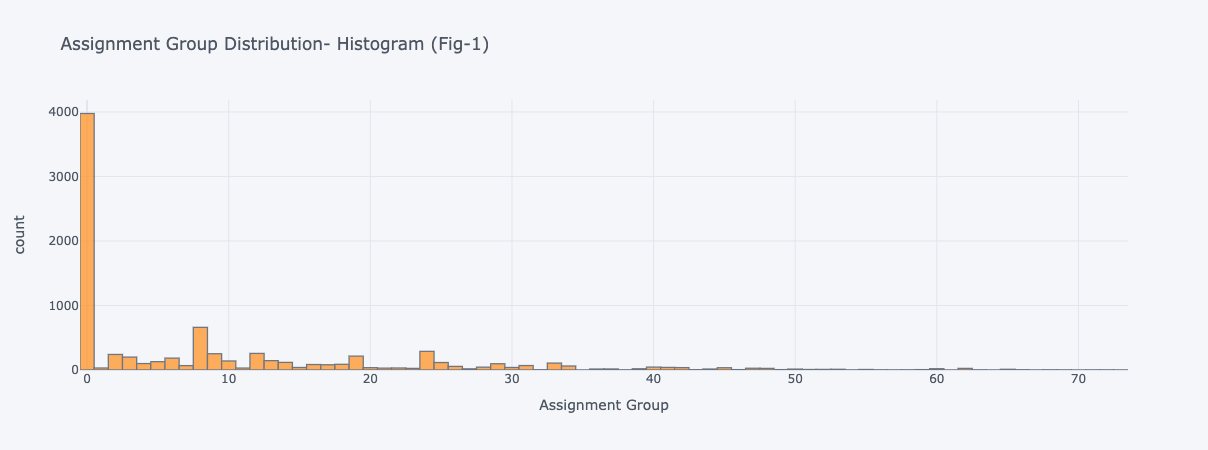

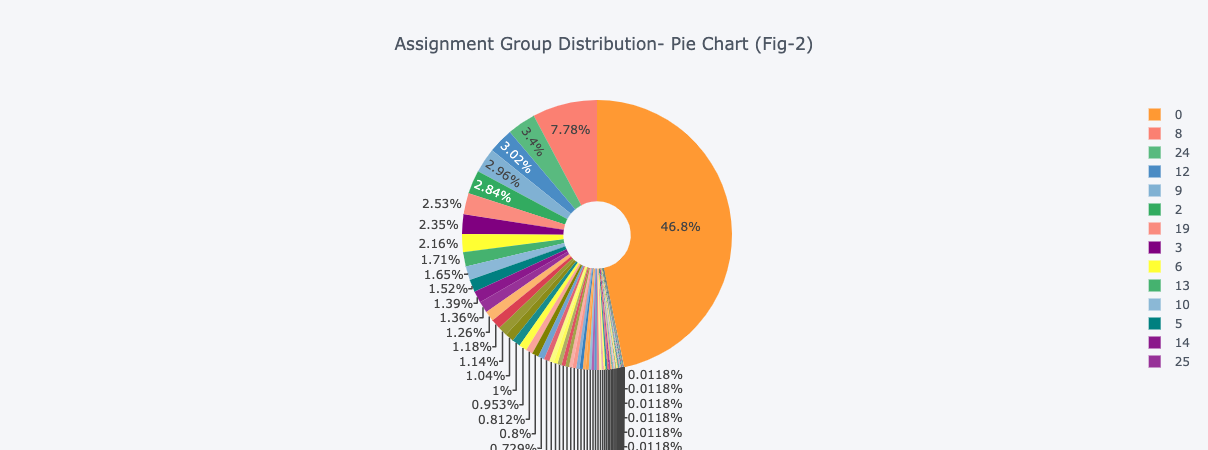

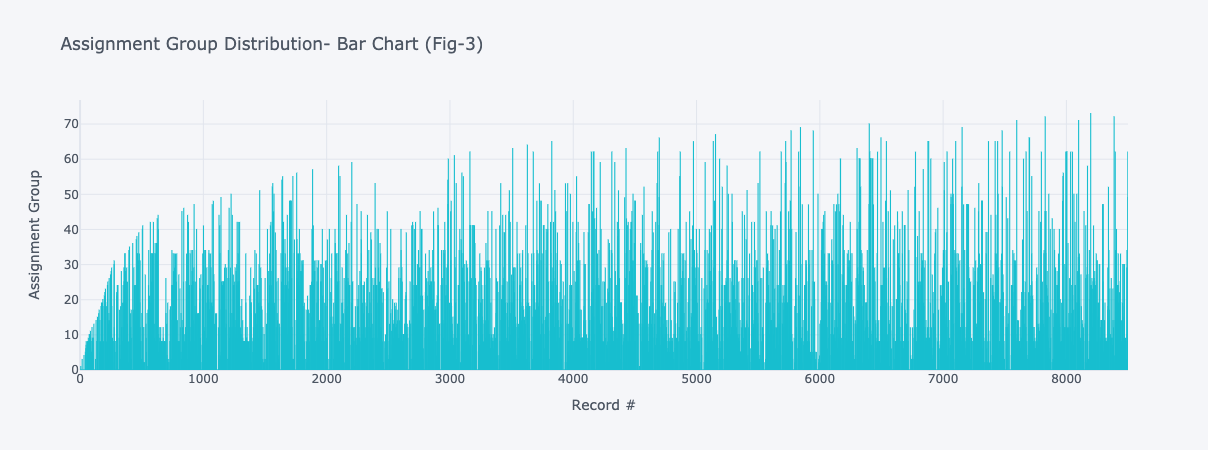

In [6]:
# Assignment group distribution
print('\033[1mTotal assignment groups:\033[0m', ticket['Assignment group'].nunique())

# Histogram
ticket['Assignment group'].iplot(
    kind='hist',
    xTitle='Assignment Group',
    yTitle='count',
    title='Assignment Group Distribution- Histogram (Fig-1)')

# Pie chart
assgn_grp = pd.DataFrame(ticket.groupby('Assignment group').size(),columns = ['Count']).reset_index()
assgn_grp.iplot(
    kind='pie', 
    labels='Assignment group', 
    values='Count', 
    title='Assignment Group Distribution- Pie Chart (Fig-2)', 
    hoverinfo="label+percent+name", hole=0.25)

# Bar plot
ticket['Assignment group'].iplot(
    kind='bar',
    yTitle='Assignment Group',
    xTitle='Record #',
    colorscale='-plotly',
    title='Assignment Group Distribution- Bar Chart (Fig-3)')

#### Central Limit Theorem
The Central Limit Theorem states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution. This fact holds especially true and practitioners have been presumably considered it for sample sizes over 30. All this is saying is that as you take more samples, especially large ones, your graph of the sample means will look more like a normal distribution.

Hence let's identify such Assignment groups which doesn't have atleast 30 tickets assigned to them and categorize them as rare group.

#Groups with less than equal to 30 tickets assigned: 40


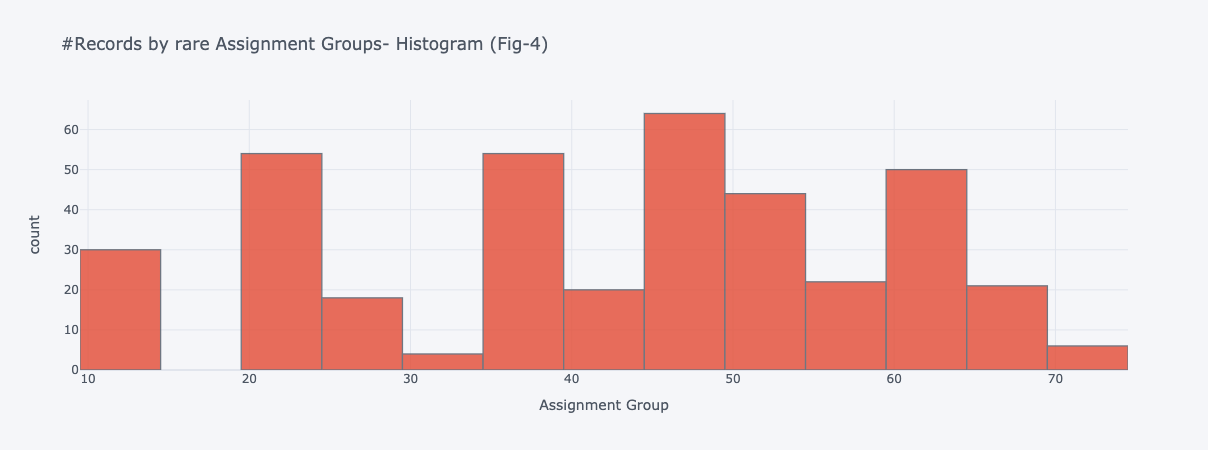

In [7]:
# Find out the Assignment Groups with less than equal to 30 tickets assigned
rare_ticket = ticket.groupby(['Assignment group']).filter(lambda x: len(x) <= 30)
print('\033[1m#Groups with less than equal to 30 tickets assigned:\033[0m', rare_ticket['Assignment group'].nunique())

rare_ticket['Assignment group'].iplot(
    kind='hist',
    xTitle='Assignment Group',
    yTitle='count',
    colorscale='-orrd',
    title='#Records by rare Assignment Groups- Histogram (Fig-4)')

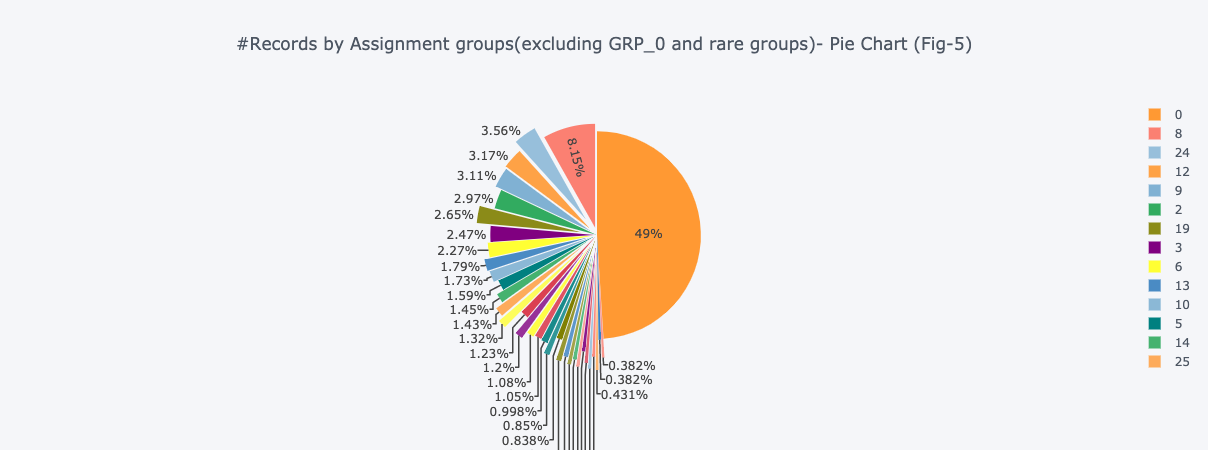

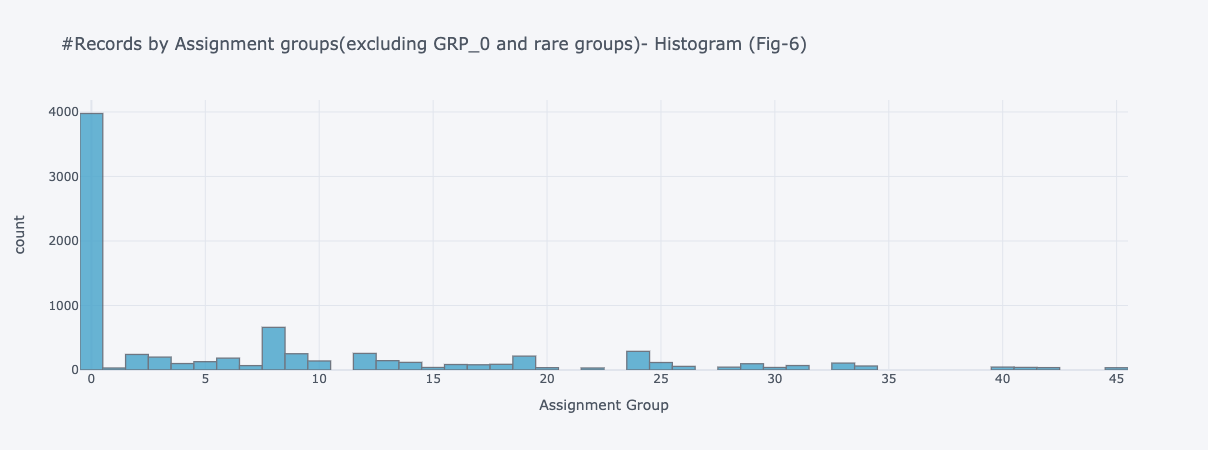

In [8]:
# Distribution of Assignment groups excluding GRP_0 & rare groups (groups with less than equal 30 tickets assigned)
excluded_grp = ['GRP_0']
excluded_grp.extend(rare_ticket['Assignment group'].unique())
filtered_tkt = ticket[~ticket['Assignment group'].isin(excluded_grp)]

# Pie chart
filtered_assgn_grp = pd.DataFrame(filtered_tkt.groupby('Assignment group').size(),columns = ['Count']).reset_index()
filtered_assgn_grp.iplot(
    kind='pie', 
    labels='Assignment group', 
    values='Count', 
    title='#Records by Assignment groups(excluding GRP_0 and rare groups)- Pie Chart (Fig-5)',
    pull=np.linspace(0,0.3,filtered_assgn_grp['Assignment group'].nunique()))

# Histogram
filtered_tkt['Assignment group'].iplot(
    kind='histogram',
    xTitle='Assignment Group',
    yTitle='count',
    colorscale='-gnbu',
    title='#Records by Assignment groups(excluding GRP_0 and rare groups)- Histogram (Fig-6)')

**Comments:**
- The bottom section of bar chart (Fig-3) is dense enough to indicate the GRP_0 is the most assigned group. So is also proved from the Histogram (Fig-1) and the pie chart (Fig-2) that tickets assigned to GRP_0 is close to 4000 out of 8500 records, which is $46.8\%$ in volume.
- The $2^{nd}$ highest assignment group is GRP_8, which is just $7.78\%$ of the total dataset and $\frac{1}{6}^{th}$ of the GRP_0
- There are 40 groups with just 30 or less tickets assigned (Fig-4), amongst which 6 groups happened to be assigned with just 1 ticket and 4 groups with just 2 tickets each.
- As assignment group attribue is the target column in our dataset, these tickets distribution shows the dataset is miserably imbalanced.

#### The distribution of Callers
Plots how the callers are associated with tickets and what are the assignment groups they most frequently raise tickets for.

Total caller count: 2950


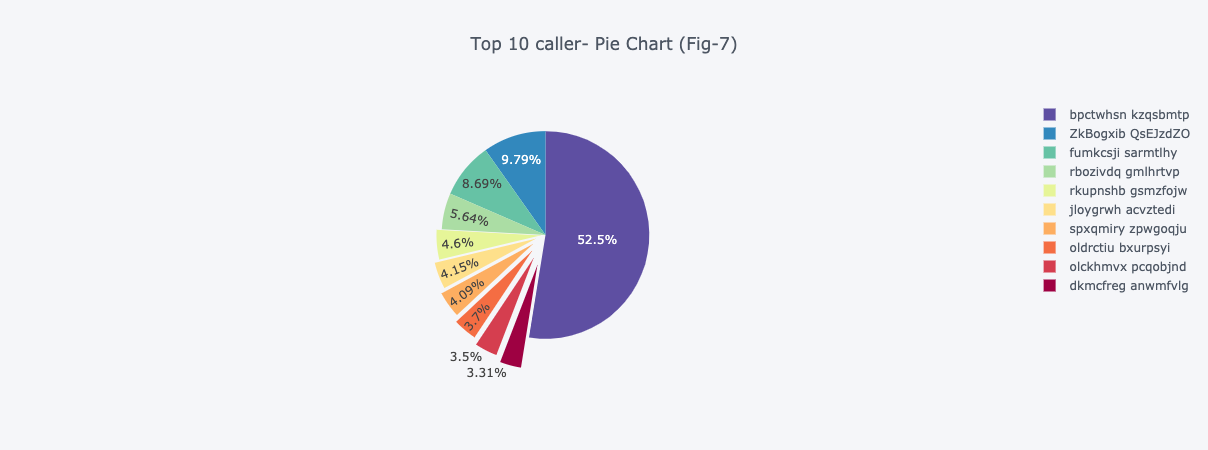

In [9]:
# Find out top 10 callers in terms of frequency of raising tickets in the entire dataset
print('\033[1mTotal caller count:\033[0m', ticket['Caller'].nunique())
df = pd.DataFrame(ticket.groupby(['Caller']).size().nlargest(10), columns=['Count']).reset_index()
df.iplot(kind='pie',
         labels='Caller', 
         values='Count', 
         title='Top 10 caller- Pie Chart (Fig-7)',
         colorscale='-spectral',
         pull=[0,0,0,0,0.05,0.1,0.15,0.2,0.25,0.3])

In [10]:
# Top 5 callers in each assignment group
top_n = 5
s = ticket['Caller'].groupby(ticket['Assignment group']).value_counts()
caller_grp = pd.DataFrame(s.groupby(level=0).nlargest(top_n).reset_index(level=0, drop=True))
caller_grp.head(15)

Caller
Assignment group Caller                   
0                fumkcsji sarmtlhy     132
                 rbozivdq gmlhrtvp      86
                 olckhmvx pcqobjnd      54
                 efbwiadp dicafxhv      45
                 mfeyouli ndobtzpw      13
1                bpctwhsn kzqsbmtp       6
                 jloygrwh acvztedi       4
                 jyoqwxhz clhxsoqy       3
                 spxqmiry zpwgoqju       3
                 kbnfxpsy gehxzayq       2
2                gzhapcld fdigznbk      16
                 ugyothfz ugrmkdhx      10
                 afkstcev utbnkyop       9
                 svdefgwl sgtmurfh       4
                 xszoedmc gmhkdsnw       4

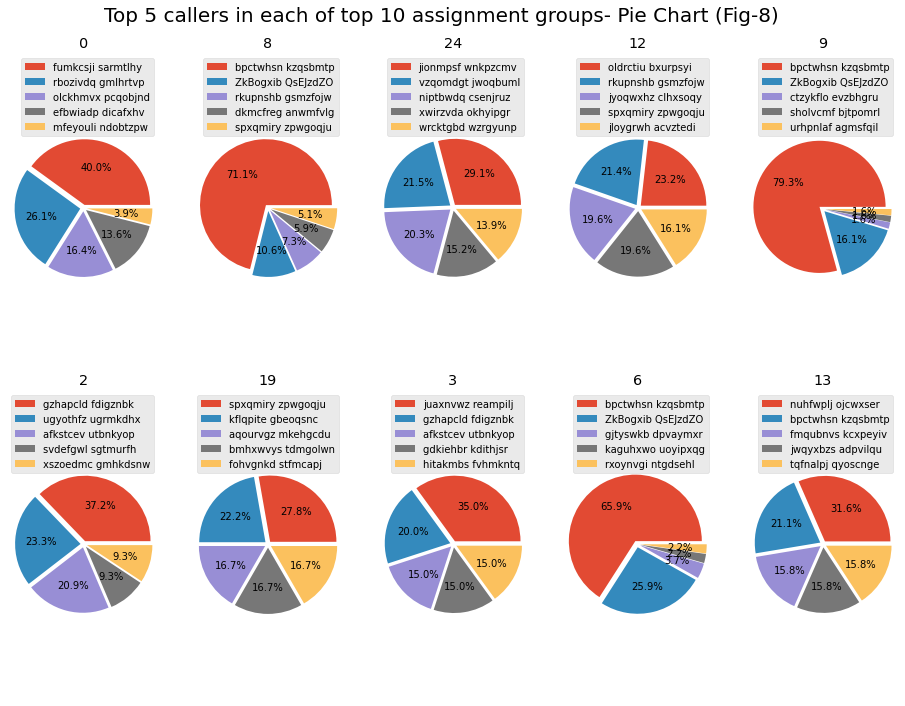

In [11]:
# Visualize Top 5 callers in each of top 10 assignment groups
top_n = 10
top_grps = assgn_grp.nlargest(top_n, 'Count')['Assignment group'].tolist()

fig_cols = 5
fig_rows = int(np.ceil(top_n/fig_cols))
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(13,9.5))
fig.suptitle('Top 5 callers in each of top 10 assignment groups- Pie Chart (Fig-8)', y=1, va= 'bottom', size='20')
for row in range(fig_rows):
    for col in range(fig_cols):
        grp_n = fig_cols * row + col
        if grp_n < top_n:
            xs = caller_grp.xs(top_grps[grp_n])
            _ = axes[row,col].pie(xs, autopct='%1.1f%%', explode=[0.05]*5)
            axes[row,col].legend(labels=xs.index,loc="best")
            axes[row,col].axis('equal')
            axes[row,col].set_title(top_grps[grp_n])

plt.tight_layout()

In [12]:
# Check if any caller appears to raise ticket for multiple groups
mul_caller = caller_grp[caller_grp.Caller.duplicated()]
uni_mul_caller = [idx[1] for idx in mul_caller.index[mul_caller.Caller.unique()]]
print(f'\033[1mFollowing {len(uni_mul_caller)} callers happen to raise tickets for multiple groups:\033[0m\n')
print(uni_mul_caller)

mul_caller

Following 15 callers happen to raise tickets for multiple groups:

['gzhapcld fdigznbk', 'afkstcev utbnkyop', 'mnlazfsr mtqrkhnx', 'hitakmbs fvhmkntq', 'rxoynvgi ntgdsehl', 'xszoedmc gmhkdsnw', 'svdefgwl sgtmurfh', 'gdkiehbr kdithjsr', 'azxhejvq fyemlavd', 'oldrctiu bxurpsyi', 'xvwchsdg pladjmxt', 'rkupnshb gsmzfojw', 'kxsceyzo naokumlb', 'ZkBogxib QsEJzdZO', 'jloygrwh acvztedi']


Caller
Assignment group Caller                   
1                spxqmiry zpwgoqju       3
2                svdefgwl sgtmurfh       4
                 xszoedmc gmhkdsnw       4
3                gzhapcld fdigznbk       4
                 afkstcev utbnkyop       3
...                                    ...
70               mfvkxghn mzjasxqd       1
71               rdfjsawg zpmxgdcw       2
72               fumkcsji sarmtlhy       1
                 ydigzqbu xdgjizek       1
73               kcnosyae zlpmfxgs       1

[281 rows x 1 columns]

**Comments:**
- There are 2950 callers have been captured in the entire dataset.
- 15 callers are identified to be involved in raising tickets for multiple assignment groups, there by contributing total 281 tickets in the dataset.
- The analysis of top 5 callers volume in each of the top 10 assignment groups shows a wide veriety of distributions in each pie chart. This is an indicative of the fact that each assignment group deals with issues impacting the business in NOT biased propertions.

#### The distribution of Short description lengths
Plots the variation of length and word count of Short description attribute

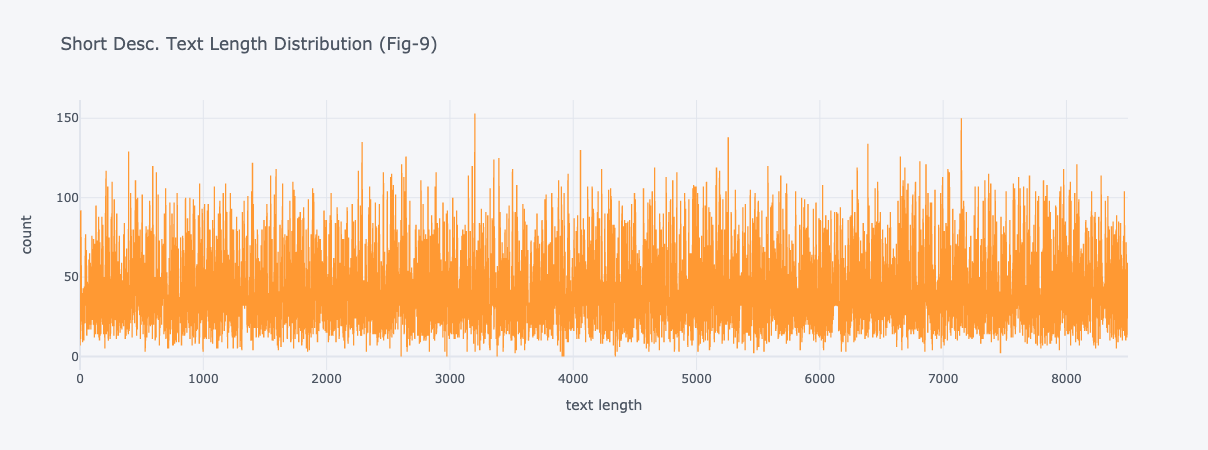

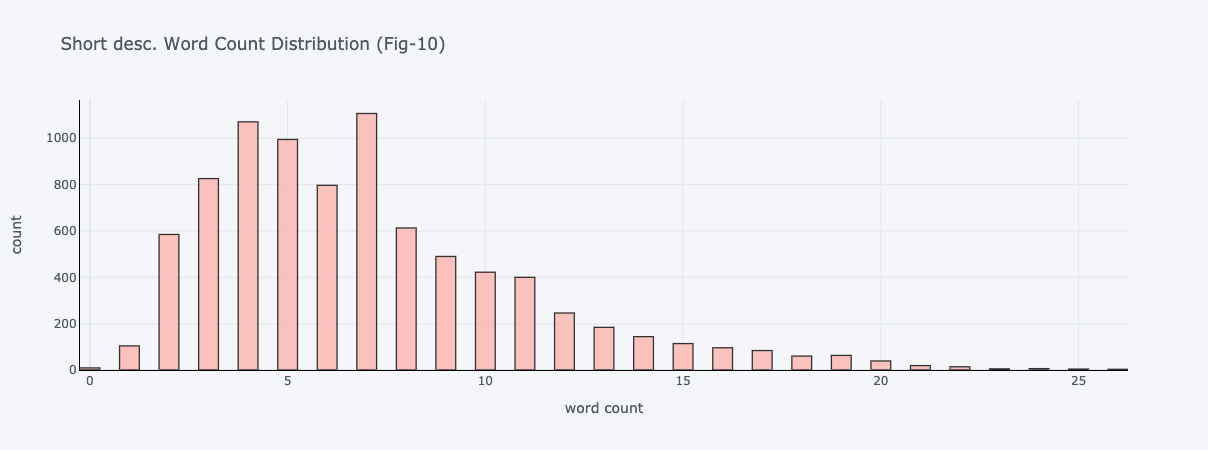

In [13]:
# Short Desc text length
ticket['sd_len'].iplot(
    kind='scatter',
    xTitle='text length',
    yTitle='count',
    title='Short Desc. Text Length Distribution (Fig-9)')

# Short desc word count
ticket['sd_word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    colorscale='pastel1',
    title='Short desc. Word Count Distribution (Fig-10)')

#### The distribution of Description lengths
Plots the variation of length and word count of Description attribute

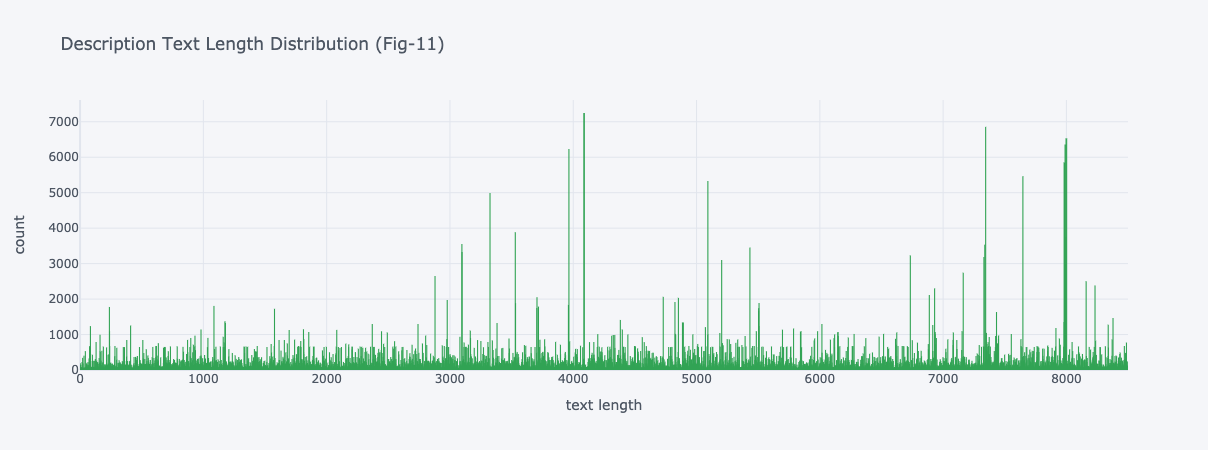

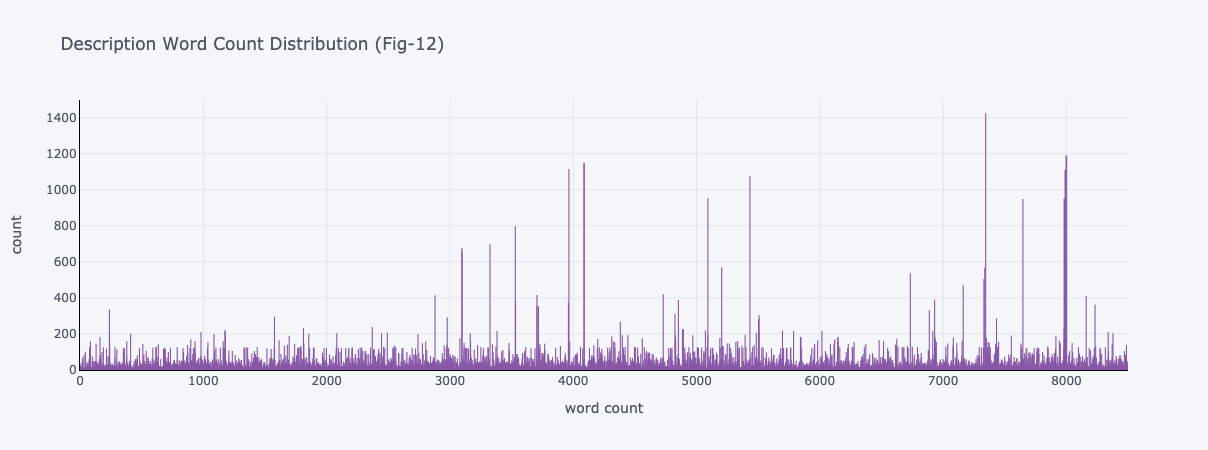

In [14]:
# Description text length
ticket['desc_len'].iplot(
    kind='bar',
    xTitle='text length',
    yTitle='count',
    colorscale='-ylgn',
    title='Description Text Length Distribution (Fig-11)')

# Description word count
ticket['desc_word_count'].iplot(
    kind='bar',
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    colorscale='-bupu',
    title='Description Word Count Distribution (Fig-12)')

#### The distribution of Language
Plots the variation of tickets recieved in different languages

Total languages detected: 4


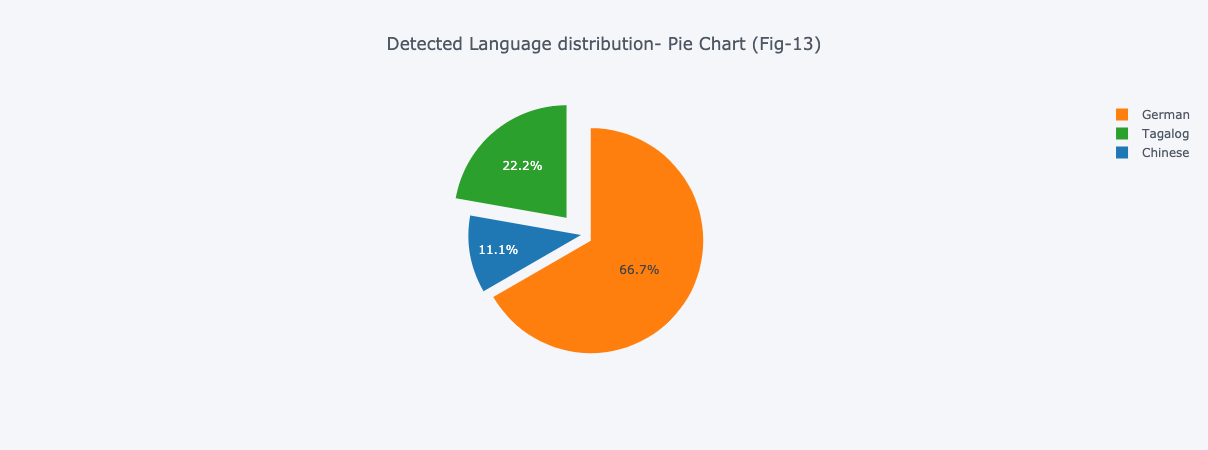

In [15]:
# Find out the volume of tickets received in different languages other than English
print('\033[1mTotal languages detected:\033[0m', ticket.Language.nunique())
df = pd.DataFrame(ticket.groupby(['Language']).size(), columns=['Count']).reset_index()

# Pie Chart
df[df.Language != 'English'].iplot(kind='pie',
         labels='Language', 
         values='Count', 
         title='Detected Language distribution- Pie Chart (Fig-13)',
         colorscale='plotly',
         pull=np.linspace(0,0.2,df.Language.nunique() - 1))

**Comments:**
- It is observed that there were quite number of people like to leave long descriptions.
- Tickets are detected to being raised in 40 various languages.

### N-Grams
N-gram is a contiguous sequence of N items from a given sample of text or speech, in the fields of computational linguistics and probability. The items can be phonemes, syllables, letters, words or base pairs according to the application. N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. 

We'll be using scikit-learn’s CountVectorizer function to derive n-grams and compare them before and after removing stop words. Stop words are a set of commonly used words in any language. We'll be using english corpus stopwords and extend it to include some business specific common words considered to be stop words in our case.

But before that let's merge the Short descrition and Description column texts and write a generic method to derive the n-grams.

In [16]:
# Merge the Short descrition and Description column texts to create a new column
ticket.insert(loc=8, 
              column='Summary', 
              allow_duplicates=True, 
              value=list(ticket['Short description'].str.strip() + ' ' + ticket['Description'].str.strip()))
# Extend the English Stop Wordss
STOP_WORDS = STOPWORDS.union({'yes','na','hi',
                              'receive','hello',
                              'regards','thanks',
                              'from','greeting',
                              'forward','reply',
                              'will','please',
                              'see','help','able'})

# Generic function to derive top N n-grams from the corpus
def get_top_n_ngrams(corpus, top_n=None, ngram_range=(1,1), stopwords=None):
    vec = CountVectorizer(ngram_range=ngram_range, 
                          stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

### Top Unigrams

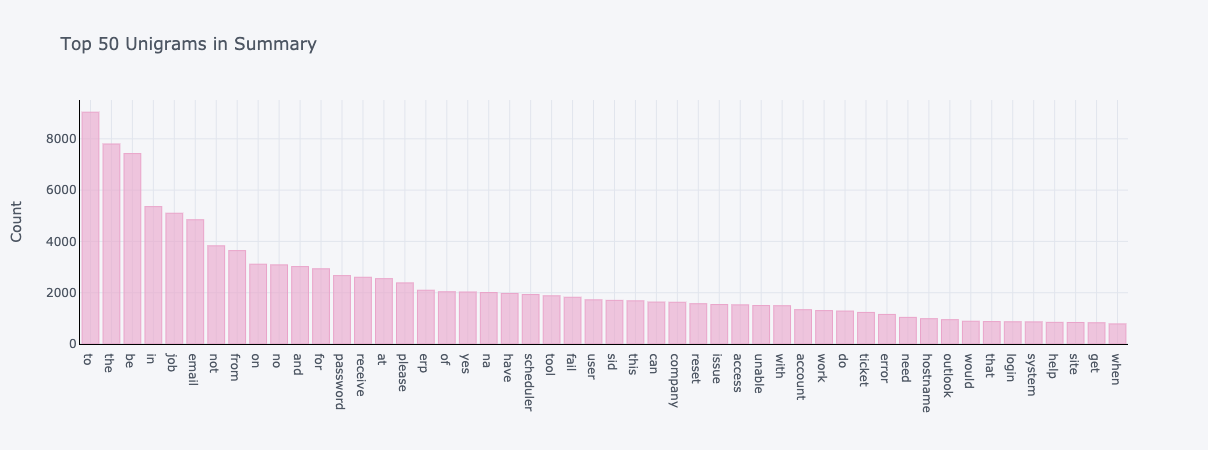

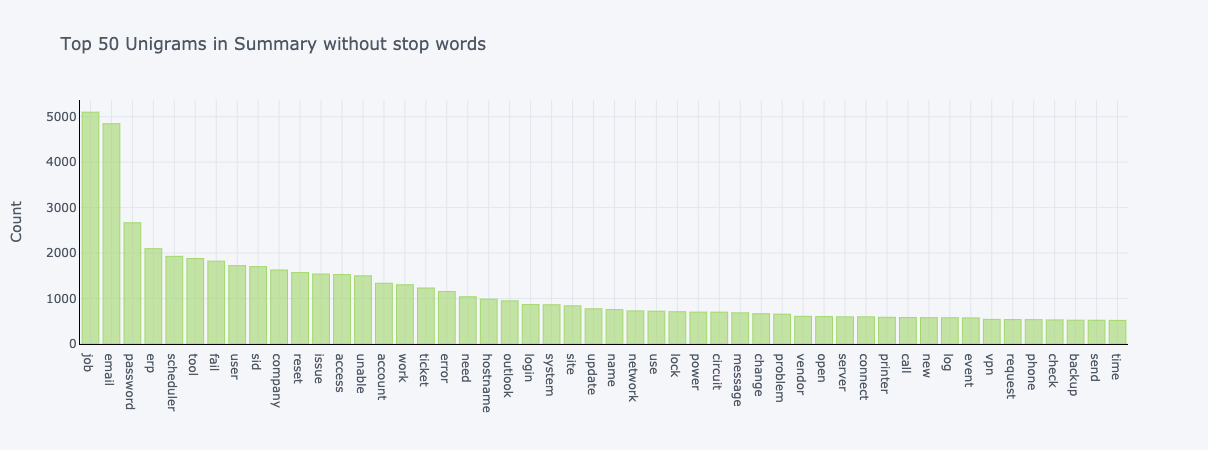

In [17]:
# Top 50 Unigrams before removing stop words
top_n = 50
ngram_range = (1,1)
uni_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(uni_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Unigrams in Summary')

# Top 50 Unigrams after removing stop words
uni_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(uni_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Unigrams in Summary without stop words')

### Top Bigrams

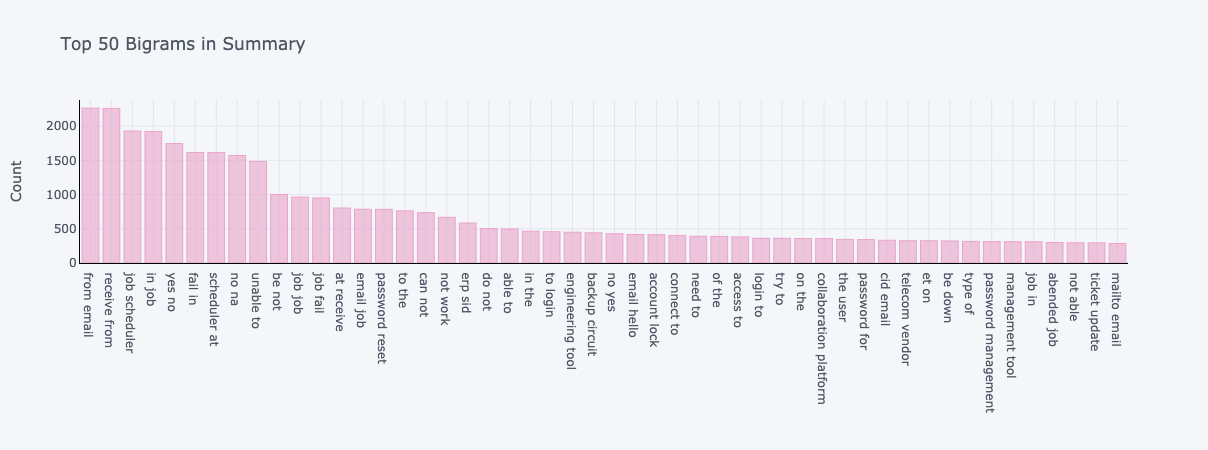

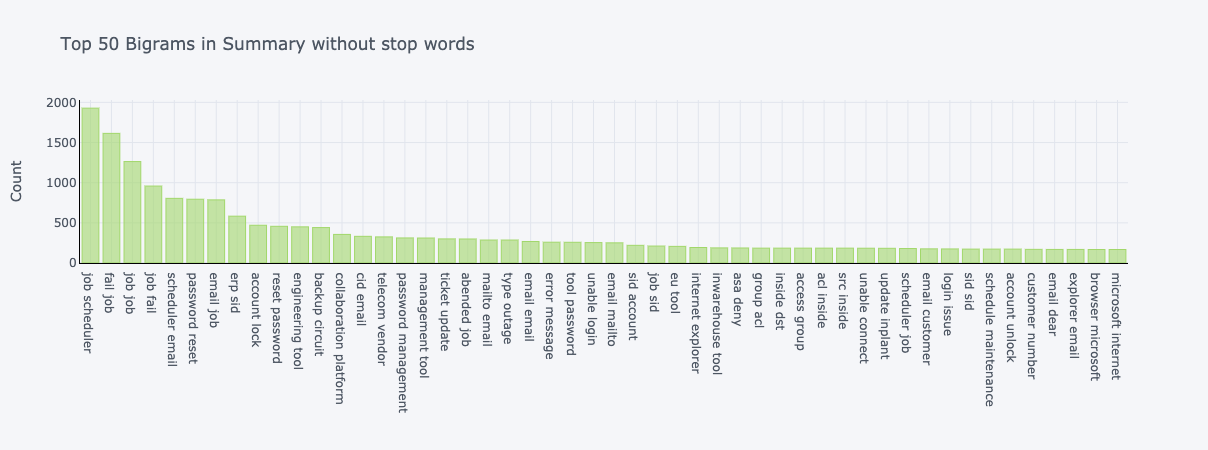

In [18]:
# Top 50 Bigrams before removing stop words
top_n = 50
ngram_range = (2,2)
bi_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(bi_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Bigrams in Summary')

# Top 50 Bigrams after removing stop words
bi_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(bi_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Bigrams in Summary without stop words')

### Top Trigrams

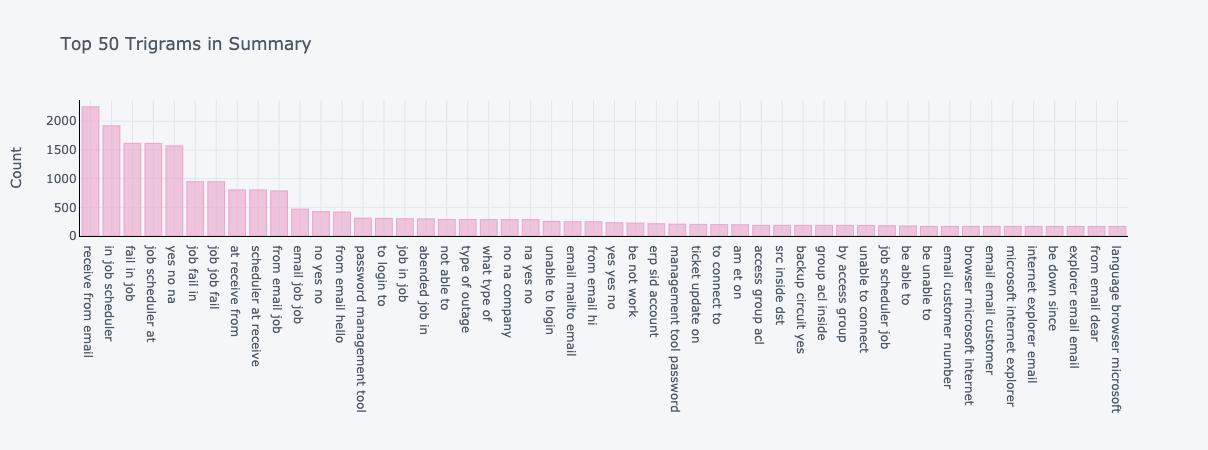

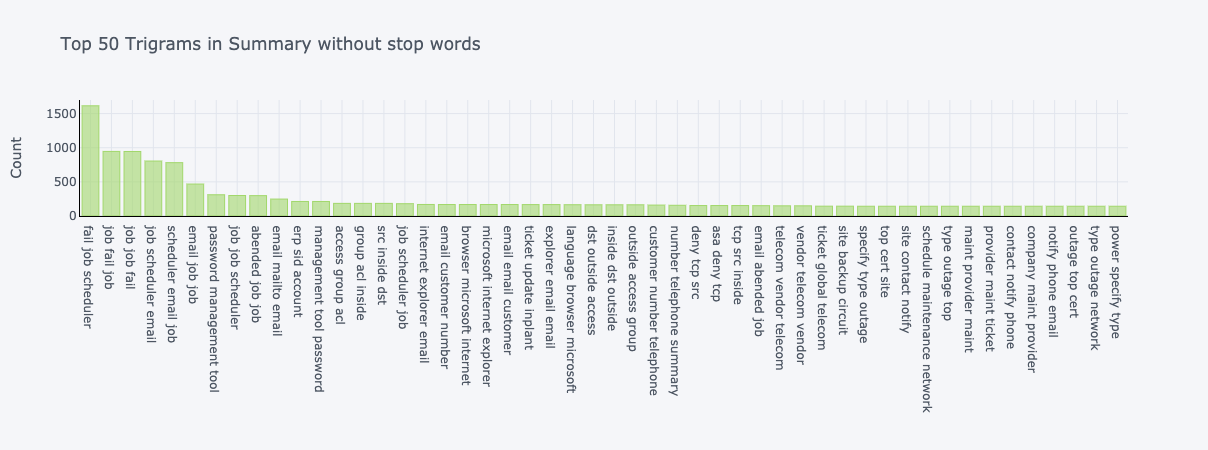

In [19]:
# Top 50 Trigrams before removing stop words
top_n = 50
ngram_range = (3,3)
tri_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(tri_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Trigrams in Summary')

# Top 50 Trigrams after removing stop words
tri_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(tri_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Trigrams in Summary without stop words')

### Word Cloud
A word cloud is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.

Also known as tag clouds or text clouds, these are ideal ways to pull out the most pertinent parts of textual data, often also help business users compare and contrast two different pieces of text to find the wording similarities between the two.

Let's write a generic method to generate Word Clouds for both Short and Long Description columns.

In [20]:
def generate_word_clod(corpus):
    # mask = np.array(Image.open('cloud2.png'))
    # Instantiate the wordcloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=STOP_WORDS,
                    # mask=mask,
                    min_font_size = 10).generate(corpus)

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

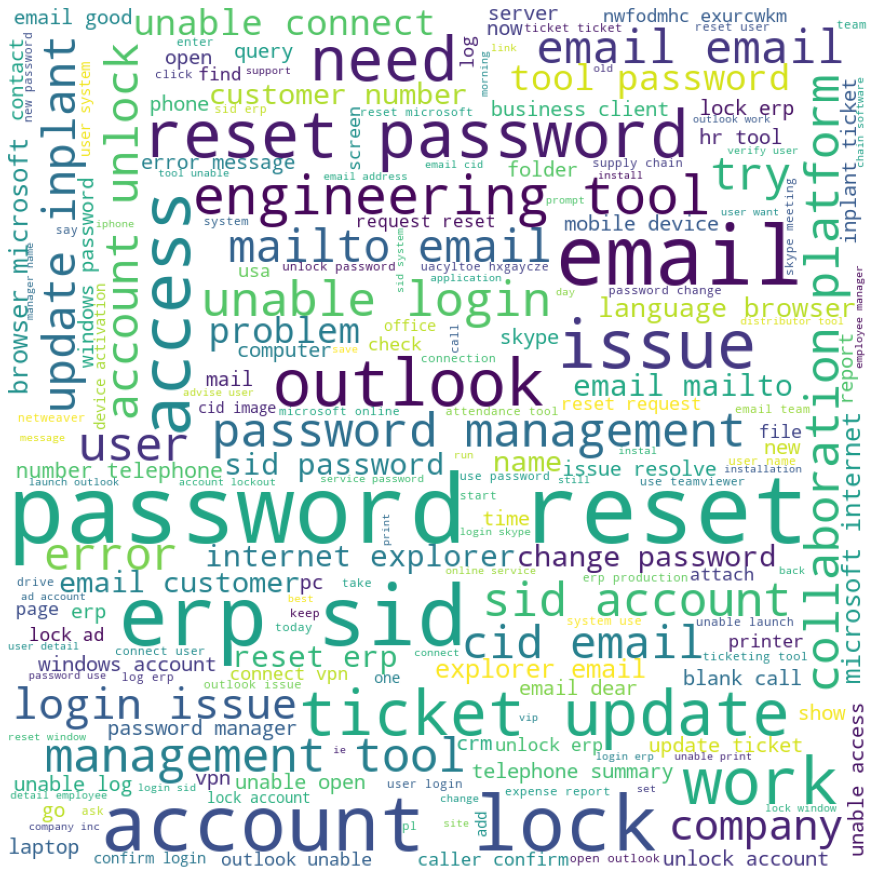

In [21]:
# Word Cloud for all tickets assigned to GRP_0
generate_word_clod(' '.join(ticket[ticket['Assignment group'] == 0].Summary.str.strip()))

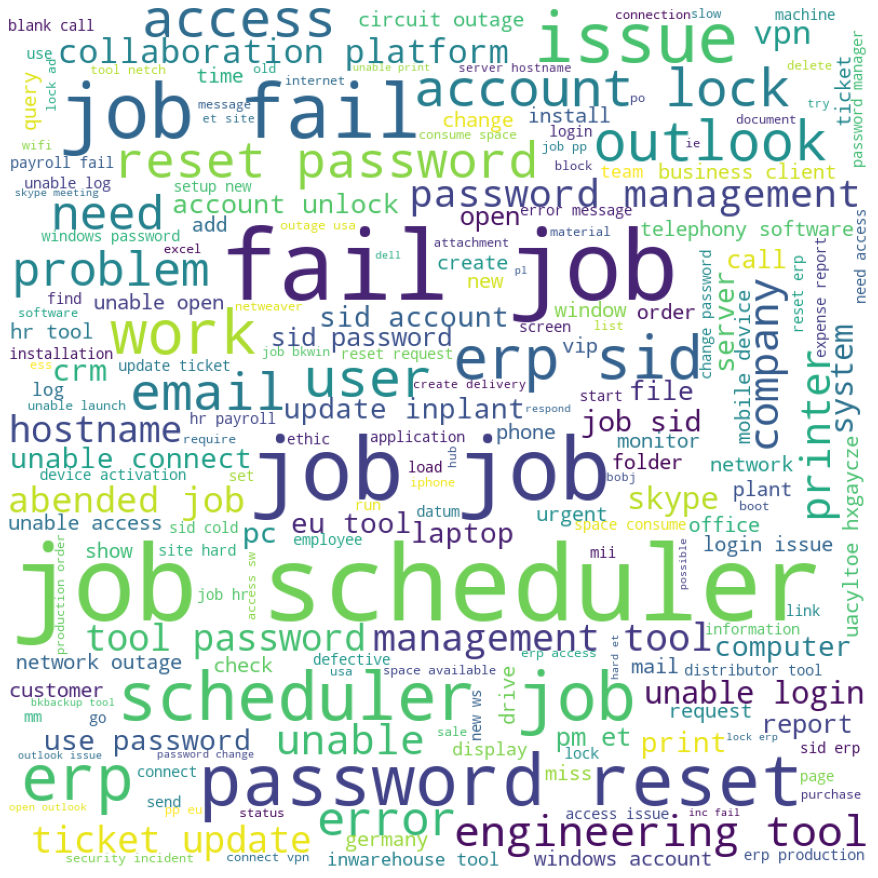

In [22]:
# Generate wordcloud for ticket Short description
generate_word_clod(' '.join(ticket['Short description'].str.strip()))

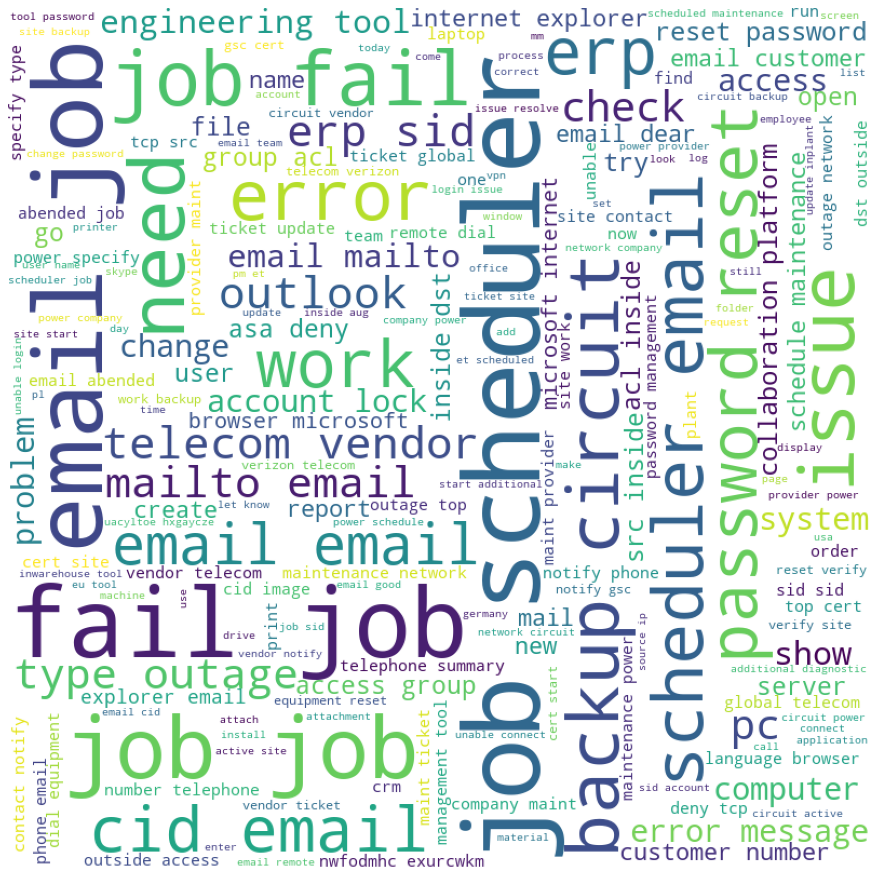

In [23]:
# Generate wordcloud for ticket Description
generate_word_clod(' '.join(ticket.Description.str.strip()))

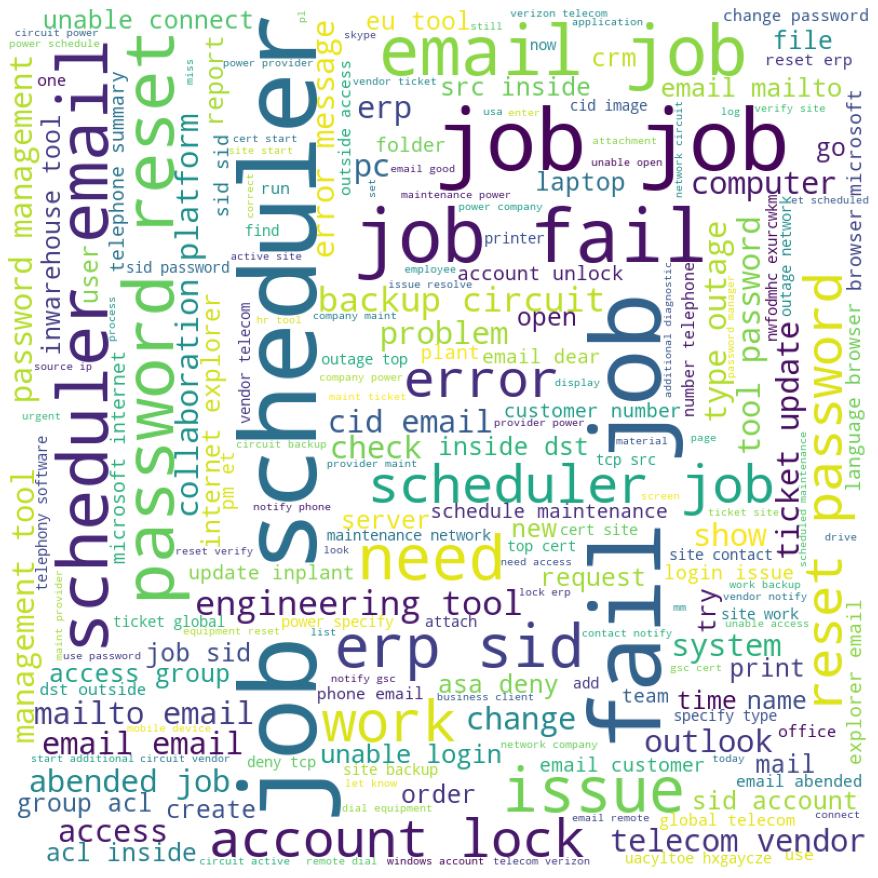

In [24]:
# Generate wordcloud for ticket Summary
generate_word_clod(' '.join(ticket.Summary.str.strip()))

In [26]:
# Serialize the dataset after EDA
with open('Models/model_ready.pkl','wb') as f:
    pickle.dump(ticket, f, pickle.HIGHEST_PROTOCOL)

**Comments:**
- It's indicative from the n-gram analysis and the word cloud is that the entire dataset speaks more about issues around
    - **password reset (1246 times)**
    - **fail job_scheduler (1614 times)**
    - **outlook (948 times)**
    - **login (861 times)**
    - **job fail (897 times)**
- Analysis on GRP_0 which is the most frequent group to assign a ticket to reveals that this group deals with mostly the maintenance problems such as *password reset*, *account lock*, *login issue*, *ticket update* etc.
- Maximum of the tickets from GRP_0 can be reduced by self correcting itself by putting automation scripts/mechanisms to help resolve these common maintenance issues. This will help in lowering the inflow of service tickets thereby saving the person/hour efforts spend and increasing the business revenue.